In [1]:
!unzip "sample_data/part_2_cnn_dataset.zip" -d "sample_data/part_2_cnn_dataset"

Archive:  sample_data/part_2_cnn_dataset.zip
replace sample_data/part_2_cnn_dataset/dogs/1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Vision Transformer (ViT) [7 pts]

## **TASK 1:** Use EfficientNet

Use [EfficientNet](https://arxiv.org/pdf/1905.11946.pdf) to solve a problem defined in Assignment 1, Part II.

You can use pre-defined EfficientNet models.

In [10]:
import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

# Folder path and classes
data_dir = 'sample_data/part_2_cnn_dataset'
classes = ['vehicles', 'food', 'dogs']

# Load images
def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = Image.open(img_path).resize((64, 64))  
        img_array = np.array(img)
        if img_array.shape == (64, 64, 3):  
            images.append(img_array)
            labels.append(label)
    return images, labels

all_images = []
all_labels = []

for idx, class_name in enumerate(classes):
    folder_path = os.path.join(data_dir, class_name)
    images, labels = load_images_from_folder(folder_path, idx)
    all_images.extend(images)
    all_labels.extend(labels)

# Convert images to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

print(f"Total number of images: {len(all_images)}")
print(f"Image array shape: {all_images.shape}")
print(f"Label array shape: {all_labels.shape}")


Total number of images: 30000
Image array shape: (30000, 64, 64, 3)
Label array shape: (30000,)


Display sample images

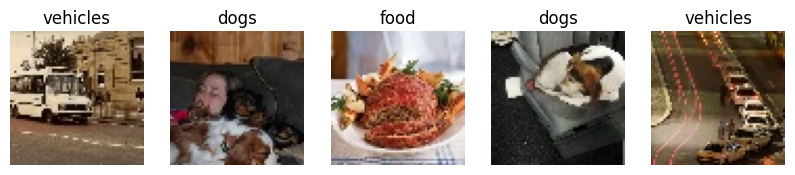

In [3]:
# sample images
def display_sample_images(images, labels, classes, num_samples=5):
    plt.figure(figsize=(10, 5))
    for i in range(num_samples):
        index = np.random.randint(0, len(images))
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[index])
        plt.title(classes[labels[index]])
        plt.axis('off')
    plt.show()

display_sample_images(all_images, all_labels, classes)


VGG-13 Version B model

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

# Define VGG-13 Version B model with 13 weight layers
class VGG13(nn.Module):
    def __init__(self, num_classes=3): # 3 classes
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Model creation
model = VGG13(num_classes=3)
print(model)


VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

Data augmentation, normalization and dataset split

In [11]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(9),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.489, 0.446, 0.416], std=[0.309, 0.254, 0.125]),
])

dataset = CustomDataset(all_images, all_labels, transform=transform)

# create train_dataset and val_dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# create train_loader, val_loader and test_loader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Training the model

In [12]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10)

num_epochs = 5
best_val_loss = float('inf')
patience = 10
early_stopping_counter = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with epoch
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    # print(len(train_loader))
    # i=0
    for inputs, labels in train_loader:
        # i=i+1
        # print(i)
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        i, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    # j=0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # j=j+1
            # print(j)
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            i, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Update learning rate scheduler
    scheduler.step(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        # Save best model weights to pickle file
        torch.save(model.state_dict(), 'dsivapra_ganeshpr.pkl')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered")
            break

    print(f"Epoch {epoch+1},\n "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%,\n "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n")

# Load best model weights from pickle file
model.load_state_dict(torch.load('dsivapra_ganeshpr.pkl'))

Epoch 1,
 Train Loss: 0.8185, Train Accuracy: 61.46%,
 Validation Loss: 0.6324, Validation Accuracy: 72.67%

Epoch 2,
 Train Loss: 0.6186, Train Accuracy: 74.71%,
 Validation Loss: 0.5681, Validation Accuracy: 76.25%

Epoch 3,
 Train Loss: 0.5803, Train Accuracy: 76.37%,
 Validation Loss: 0.5388, Validation Accuracy: 79.00%

Epoch 4,
 Train Loss: 0.5509, Train Accuracy: 78.21%,
 Validation Loss: 0.4852, Validation Accuracy: 80.85%

Epoch 5,
 Train Loss: 0.5332, Train Accuracy: 79.12%,
 Validation Loss: 0.4772, Validation Accuracy: 82.05%



<All keys matched successfully>

Calculate Test loss and accuracy

In [13]:
model.eval()
test_loss = 0.0
correct_test = 0
total_test = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        i, predicted = torch.max(outputs, 1)
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.4704, Test Accuracy: 82.53%


Plotting training and validation accuracy and loss

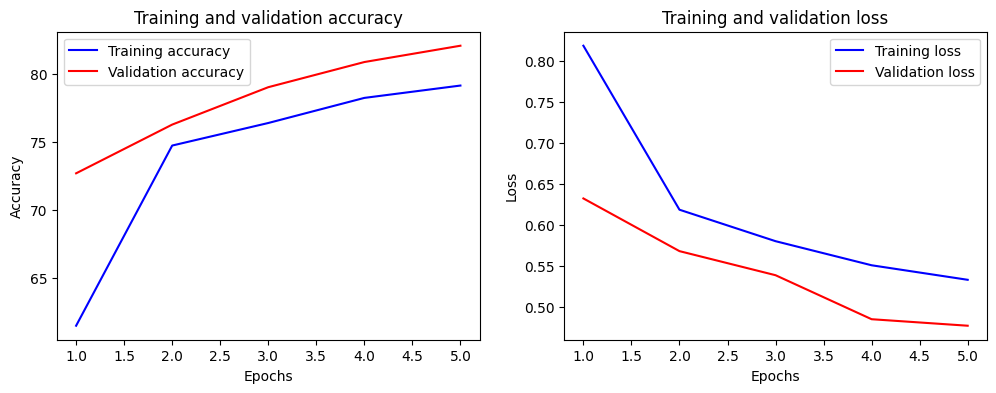

In [14]:
# Plotting training and validation accuracy and loss
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Confusion Matrix and evaluation metrics

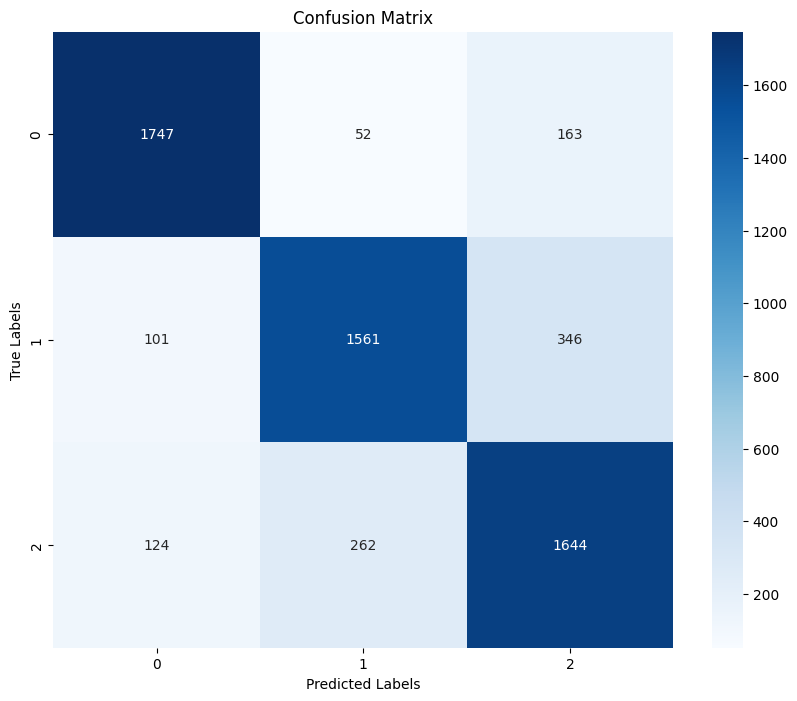

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1962
           1       0.83      0.78      0.80      2008
           2       0.76      0.81      0.79      2030

    accuracy                           0.83      6000
   macro avg       0.83      0.83      0.83      6000
weighted avg       0.83      0.83      0.83      6000



In [15]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Classification Report
print("Classification Report:\n", classification_report(all_labels, all_predictions))

In [16]:
!pip install efficientnet-pytorch


EfficientNet Implementation


In [17]:
# Import EfficientNet
from efficientnet_pytorch import EfficientNet

# Model creation for EfficientNet
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=3)

# Modify the last layer of EfficientNet to match our number of classes
num_ftrs = efficientnet_model._fc.in_features
efficientnet_model._fc = nn.Linear(num_ftrs, 3)

print(efficientnet_model)

# Training function
def train_model(model, num_epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=10)

    best_val_loss = float('inf')
    patience = 10
    early_stopping_counter = 0

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pkl')
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= patience:
                print("Early stopping triggered")
                break

        print(f"Epoch {epoch+1},\n "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%,\n "
              f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%\n")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Train EfficientNet model(using same number of epochs to compare with VGG easily)
efficientnet_train_losses, efficientnet_val_losses, efficientnet_train_accuracies, efficientnet_val_accuracies = train_model(efficientnet_model, num_epochs=5)

# Load best model weights for evaluation
def evaluate_model(model):
    model.load_state_dict(torch.load('best_model.pkl'))
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    test_loss = 0.0
    correct_test = 0
    total_test = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct_test / total_test

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    return all_labels, all_predictions



Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

Evaluation of EfficientNet


In [20]:
# Evaluate EfficientNet model
efficientnet_labels, efficientnet_predictions = evaluate_model(efficientnet_model)

# Plotting training and validation accuracy and loss for EfficientNet
epochs = range(1, len(efficientnet_train_losses) + 1)

print("EfficientNet Classification Report:\n", classification_report(efficientnet_labels, efficientnet_predictions))


Test Loss: 0.1228, Test Accuracy: 96.00%
EfficientNet Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97      1962
           1       0.98      0.94      0.96      2008
           2       0.93      0.97      0.95      2030

    accuracy                           0.96      6000
   macro avg       0.96      0.96      0.96      6000
weighted avg       0.96      0.96      0.96      6000





## **TASK 2:** Compare the Results with VGG

EfficientNet has more accuracy and less loss when compared to VGG model


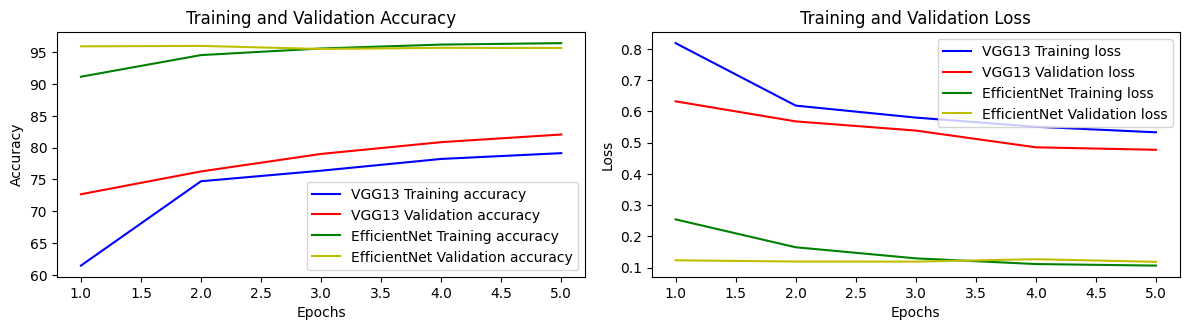

In [19]:
# Plotting training and validation accuracy and loss for VGG13 and EfficientNet
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 6))

# Plotting training and validation accuracy
plt.subplot(2, 2, 1)
plt.plot(epochs, train_accuracies, 'b', label='VGG13 Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='VGG13 Validation accuracy')
plt.plot(epochs, efficientnet_train_accuracies, 'g', label='EfficientNet Training accuracy')
plt.plot(epochs, efficientnet_val_accuracies, 'y', label='EfficientNet Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(2, 2, 2)
plt.plot(epochs, train_losses, 'b', label='VGG13 Training loss')
plt.plot(epochs, val_losses, 'r', label='VGG13 Validation loss')
plt.plot(epochs, efficientnet_train_losses, 'g', label='EfficientNet Training loss')
plt.plot(epochs, efficientnet_val_losses, 'y', label='EfficientNet Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


## **References**

Include all the references that have been used to complete the assignment.

Used the code and changed the hyperparameters  from Assignment1 part2 code for VGG model implementation, training and evaluation. REF: dsivapra_rkota2_assignment1_part_2